In [2]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# Numarul decanale in imaginile de antrenare, in cazul nostru avem imagini color nc = 3
nc = 3

# Marimea vector latent de intrare in Generator
nz = 100

# Dimensiunea hartii cu caracteristici (feature map) in Generator
ngf = 64

# Dimensiunea hartii cu caracteristici (feature map) in Discriminator
ndf = 64

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input z: vector de zgomot
            nn.ConvTranspose2d(
                in_channels=nz,
                out_channels=ngf * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # dimensiune: (ngf * 8) x 4 x 4

            nn.ConvTranspose2d(
                in_channels=ngf * 8,
                out_channels=ngf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # dimensiune: (ngf * 4) x 8 x 8

            nn.ConvTranspose2d(
                in_channels=ngf * 4,
                out_channels=ngf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # dimensiune: (ngf * 2) * 16 * 16

            nn.ConvTranspose2d(
                in_channels=ngf * 2,
                out_channels=ngf,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # dimensiune: (ngf) * 32 * 32

            nn.ConvTranspose2d(
                in_channels=ngf,
                out_channels=nc,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.Tanh()
            # dimensiune: (nc) * 64 * 64
        )

    def forward(self, x):
        return self.main(x)

In [5]:
# Instantiem Generator
generator = Generator()

# Incarcam parametrii deja antrenati
generator.load_state_dict(torch.load('generator.pth', map_location=torch.device('cpu')))

# Setam modelul pe mod de evaluare
generator.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

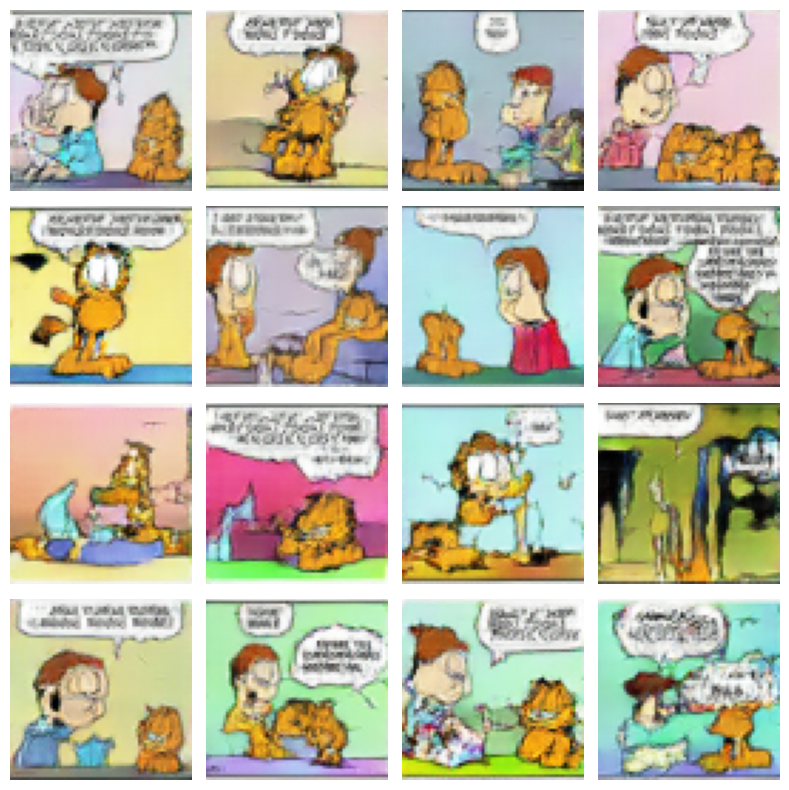

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# dimensiune vector de zgomot
noise_dim = 100

# Generam zogomotul
fixed_noise = torch.randn(16, noise_dim, 1, 1)  # 16 imagini

# trecem zgomotul prin Generator
with torch.no_grad():  # Nu calculam gradienti
    fake_images = generator(fixed_noise)


fake_images = (fake_images + 1) / 2

# Plotare
fig, axes = plt.subplots(4, 4, figsize=(8,8))
for i, ax in enumerate(axes.flatten()):
    img = fake_images[i].permute(1, 2, 0).cpu().numpy()  # rearrange to (H,W,C)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()


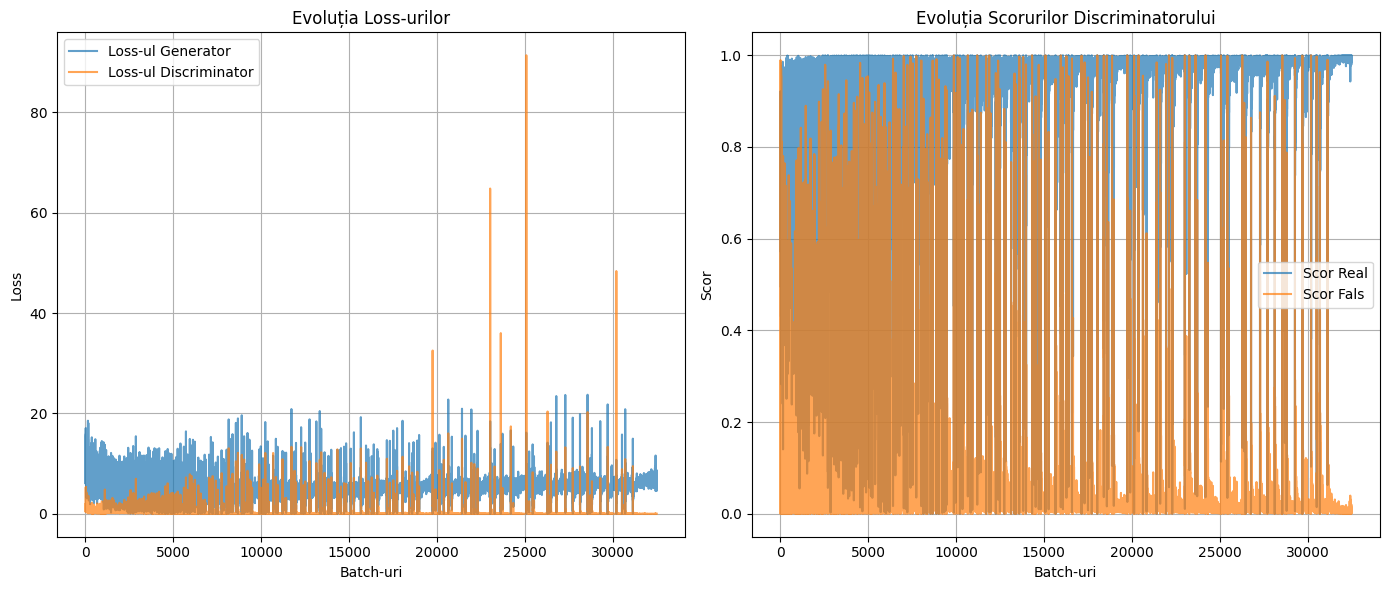

In [21]:
import pickle

# Descarcam statisticile din fisierul .pkl
with open("training_stats.pkl", "rb") as f:
    data = pickle.load(f)

# Extragem listele
losses_G = data.get("G_losses", [])
losses_D = data.get("D_losses", [])
real_score_list = data.get("real_score_list", [])
fake_score_list = data.get("fake_score_list", [])

# Plotarea:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(losses_G, label='Loss-ul Generator', alpha=0.7)
ax1.plot(losses_D, label='Loss-ul Discriminator', alpha=0.7)
ax1.set_title('Evoluția Loss-urilor')
ax1.set_xlabel('Batch-uri')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(real_score_list, label='Scor Real', alpha=0.7)
ax2.plot(fake_score_list, label='Scor Fals', alpha=0.7)
ax2.set_title('Evoluția Scorurilor Discriminatorului')
ax2.set_xlabel('Batch-uri')
ax2.set_ylabel('Scor')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
